# Parte 1
## Análisis de Sentimientos

### Limpieza de Datos

#### Import and Data Shaping

Primero realizamos los imports necesarios.

In [ ]:
import numpy as np 
import pandas as pd
import re 

import matplotlib.pyplot as plt
import seaborn as sns

import os

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
from nltk.stem import SnowballStemmer

import eli5

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

from dtreeviz.trees import *

import graphviz

from string import punctuation

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 5.1 MB/s 
     |████████████████████████████████| 133 kB 41.9 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=126d9dbd7a763db08a04a832768098171fd2262aa868ffa5885112fc7f6cfd1a
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is inco

Importamos el set de datos de reviews de ropa de mujeres

In [ ]:
months = {
            'January': 1,
            'February': 2,
            'March': 3,
            'April': 4,
            'May': 5,
            'June': 6,
            'July': 7,
            'August': 8,
            'September': 9, 
            'October': 10,
            'November': 11,
            'December': 12
         }

month_to_num = lambda m: months[m]

In [ ]:
df = pd.read_csv('womens_clothing_reviews.csv', encoding='latin-1')
reviews = df.copy()
reviews

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [ ]:
df.columns

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

In [ ]:
df.drop(columns=['Unnamed: 0', 'Clothing ID'], inplace=True)
df

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...
23481,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


Para hacer análisis de sentimientos nos resultará útil tener un dataframe únicamente con las reviews mappeadas a sus respectivos ratings.

### Análisis Exploratorio

In [ ]:
analyzable = df.dropna(inplace=False)
analyzable

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits
...,...,...,...,...,...,...,...,...,...
23481,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      23486 non-null  int64 
 1   Title                    19676 non-null  object
 2   Review Text              22641 non-null  object
 3   Rating                   23486 non-null  int64 
 4   Recommended IND          23486 non-null  int64 
 5   Positive Feedback Count  23486 non-null  int64 
 6   Division Name            23472 non-null  object
 7   Department Name          23472 non-null  object
 8   Class Name               23472 non-null  object
dtypes: int64(4), object(5)
memory usage: 1.6+ MB


A continuación indicamos que representa cada columna del dataframe:

- **Age:** Edad del crítico.
- **Title:** Título de la crítica.
- **Review Text**: Cuerpo de la crítica. 
- **Rating:** Puntuación del producto según el consumidor, siendo 1 la peor y 5 la mejor. 
- **Recommended IND:** Variable binaria donde 1 significa que el consumidor lo recomienda y 0 no.
- **Positive Feedback Count:** Número de otros consumidores que encontraron positiva la crítica.
- **Division Name:** Nombre categórico de la división de alto nivel(más general) del producto.
- **Department Name:** Nombre categórico del departamento del producto.
- **Class Name:** Nombre categórico de la clase del producto.

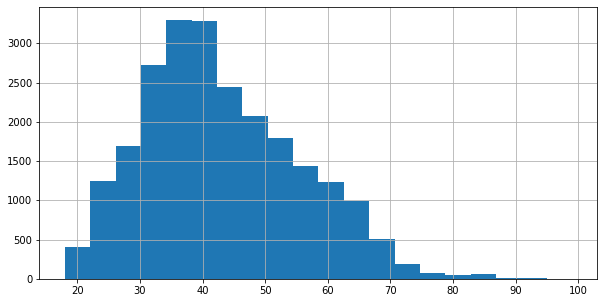

In [ ]:
df.Age.hist(bins=20, figsize = (10,5))

[Text(0.5, 1.0, 'Boxplot de la Edad')]

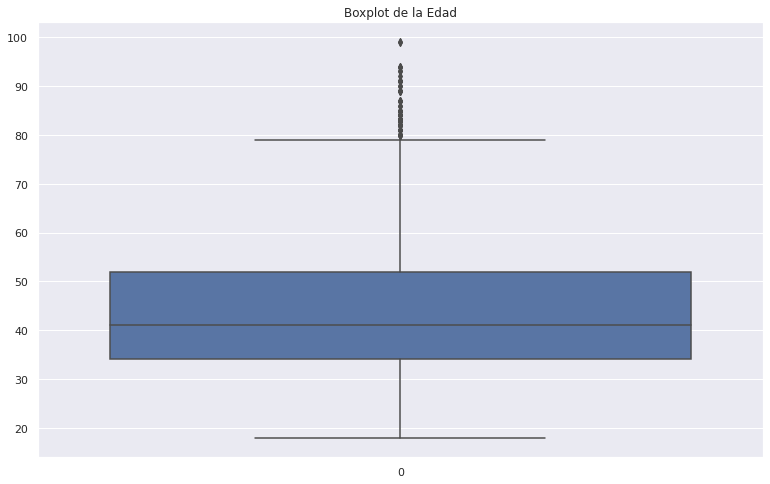

In [ ]:
sns.set(rc = {'figure.figsize':(13,8)})
sns.boxplot(data=df.Age).set(title="Boxplot de la Edad")

(3.5, 4.5)

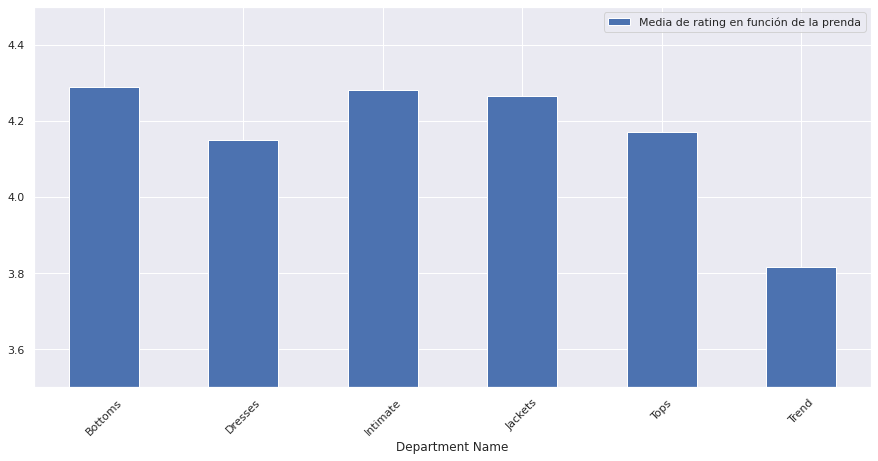

In [ ]:
xd = df.groupby("Department Name").agg({'Rating': ['mean']})
xd.plot.bar(figsize = (15,7), rot = 45)
plt.legend(['Media de rating en función de la prenda'])
plt.ylim(3.5, 4.5)

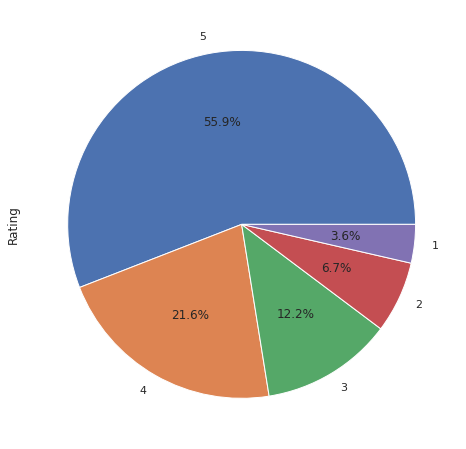

In [ ]:
df['Rating'].value_counts().plot.pie(autopct='%1.1f%%')

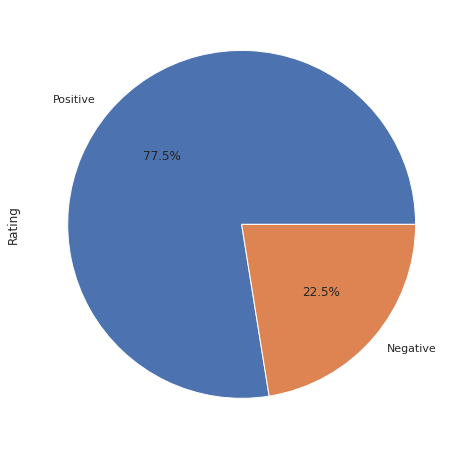

In [ ]:
df['Rating'].map(lambda x: 'Positive' if x > 3 else 'Negative').value_counts().plot.pie(autopct='%1.1f%%')

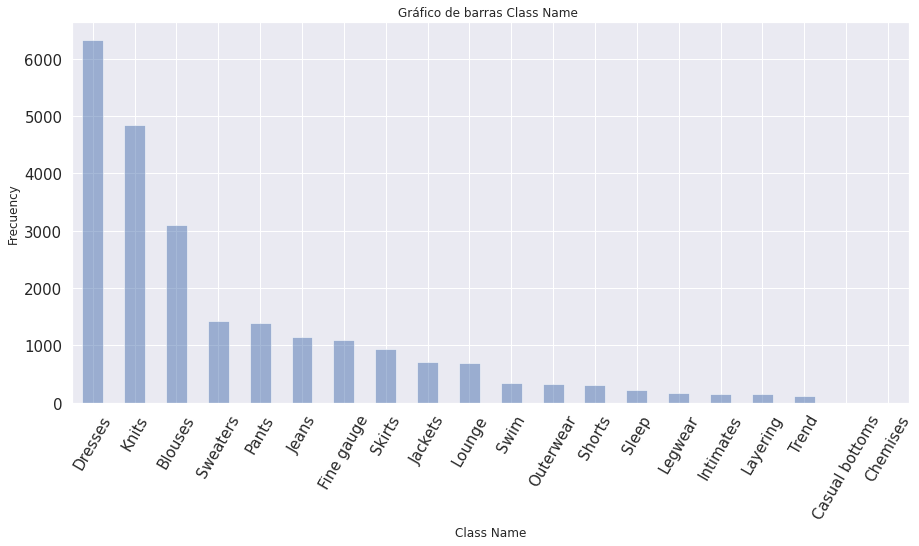

In [ ]:
#No se si esta bien este grafico :C
df['Class Name'].value_counts().plot.bar(alpha=0.5,figsize = (15,7), fontsize = 15, rot = 60,
                                         title="Gráfico de barras Class Name ",
                                         xlabel="Class Name", ylabel="Frecuency")

### Preparación de las Columnas para el Entrenamiento

In [ ]:
reviews_and_ratings = reviews[['Review Text', 'Rating']].copy()
reviews_and_ratings

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,4
1,Love this dress! it's sooo pretty. i happene...,5
2,I had such high hopes for this dress and reall...,3
3,"I love, love, love this jumpsuit. it's fun, fl...",5
4,This shirt is very flattering to all due to th...,5
...,...,...
23481,I was very happy to snag this dress at such a ...,5
23482,"It reminds me of maternity clothes. soft, stre...",3
23483,"This fit well, but the top was very see throug...",3
23484,I bought this dress for a wedding i have this ...,3


#### Verificación nulls

In [ ]:
reviews_and_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review Text  22641 non-null  object
 1   Rating       23486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 367.1+ KB


Vemos que hay cantidades diferentes de reviews y ratings no nulos, por lo que vamos a sacar los datos inválidos.

In [ ]:
reviews_and_ratings.dropna(inplace=True)
reviews_and_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22641 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review Text  22641 non-null  object
 1   Rating       22641 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 530.6+ KB


In [ ]:
reviews_and_ratings

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,4
1,Love this dress! it's sooo pretty. i happene...,5
2,I had such high hopes for this dress and reall...,3
3,"I love, love, love this jumpsuit. it's fun, fl...",5
4,This shirt is very flattering to all due to th...,5
...,...,...
23481,I was very happy to snag this dress at such a ...,5
23482,"It reminds me of maternity clothes. soft, stre...",3
23483,"This fit well, but the top was very see throug...",3
23484,I bought this dress for a wedding i have this ...,3


Al hacer el `dropna()`, se están salteando índices. Para arreglar esto, vamos a resetear los índices con el método `reset_index()`.

In [ ]:
reviews_and_ratings.reset_index(inplace=True)
reviews_and_ratings.drop(columns=['index'], inplace=True)
reviews_and_ratings

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,4
1,Love this dress! it's sooo pretty. i happene...,5
2,I had such high hopes for this dress and reall...,3
3,"I love, love, love this jumpsuit. it's fun, fl...",5
4,This shirt is very flattering to all due to th...,5
...,...,...
22636,I was very happy to snag this dress at such a ...,5
22637,"It reminds me of maternity clothes. soft, stre...",3
22638,"This fit well, but the top was very see throug...",3
22639,I bought this dress for a wedding i have this ...,3


Transformamos la variable a predecir como se pide en la consigna.

In [ ]:
reviews_and_target = reviews_and_ratings.copy()
reviews_and_target['Good Ratings'] = reviews_and_target.Rating >= 4
reviews_and_target.drop(columns=['Rating'], inplace=True)
reviews_and_target

,Review Text,Good Ratings
0,Absolutely wonderful - silky and sexy and comf...,True
1,Love this dress! it's sooo pretty. i happene...,True
2,I had such high hopes for this dress and reall...,False
3,"I love, love, love this jumpsuit. it's fun, fl...",True
4,This shirt is very flattering to all due to th...,True
...,...,...
22636,I was very happy to snag this dress at such a ...,True
22637,"It reminds me of maternity clothes. soft, stre...",False
22638,"This fit well, but the top was very see throug...",False
22639,I bought this dress for a wedding i have this ...,False


### Entrenamiento con el método Regresión Logistica

Descargamos los stopwords a utilizar y el stemmer. Los stopwords los excluimos y utilizaremos un stemmer para llevar cada palabra a su raíz léxica. Definimos también un conjunto de caracteres excluidos.

In [ ]:
tokenizer = ToktokTokenizer() 
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")

excluded_chars = {'_'}

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


- Para el tokenizador de abajo definimos el siguiente flujo de filtrado:
    - Filtramos con expresiones regulares valores no alfanuméricos y espacios innecesarios.
    - Luego nos quedamos con los tokens con tamaño mayor a uno.
    - Posteriormente eliminamos los stopwords y números.
    - Pasamos los tokens por un stemmer.
    - Y finalmente eliminamos las palabras que sean completamente compuestas por carácteres inválidos (en nuestro caso, necesitamos filtrar el barra baja).

In [ ]:
def negate_tokens(text) -> str:
    words = [l for l in re.findall(r"[\w']+|[.,!?;]", text) if l != '']
    must_negate_prefix = False
    to_return = []
    for l in words:
        if l == 'no' or l == 'not':
            must_negate_prefix = True
        elif l in '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~':
            must_negate_prefix = False
        elif must_negate_prefix:
            l = "NOT_" + l
        to_return.append(l)
    return ' '.join(to_return)

In [ ]:
has_valid_chars = lambda w: not (len(set(w)) == 1 and set(w).pop() in excluded_chars)
regex_filter = lambda text: re.sub(r'\s+', ' ', re.sub(r'\W', ' ', str(text)), flags = re.I)
filter_words = lambda tokens: [token for token in tokens if token not in stop_words and not token.isdigit() and len(token) > 1]
word_stemmer = lambda tokens: [stemmer.stem(token) for token in tokens]
filter_stemd = lambda words: [w for w in words if has_valid_chars(w)]

def tokenize(text):
    clean_text = regex_filter(negate_tokens(text))
    tokens = [w for w in tokenizer.tokenize(clean_text)]
    stems = word_stemmer(tokens)
    tokens = filter_words(tokens)
    return filter_stemd(stems)

Separamos el conjunto de entrenamiento como un 70% aleatorio del set de datos mientras que el otro 30% queda para el set de testing.

In [ ]:
reviews = reviews_and_target['Review Text']
ratings = reviews_and_target['Good Ratings']

X_train, X_test, y_train, y_test = train_test_split(reviews, ratings, test_size = 0.3, random_state=2)

Verificamos que las dimensiones matcheen:

In [ ]:
X_train.shape, y_train.shape

((15848,), (15848,))

In [ ]:
X_test.shape, y_test.shape

((6793,), (6793,))

Instanciamos el vectorizador de palabras, el cual utiliza TF-IDF.

In [ ]:
tfidf = TfidfVectorizer(
    tokenizer=tokenize,
    max_features=20000)  

tfidf.fit(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


TfidfVectorizer(max_features=20000,
                tokenizer=<function tokenize at 0x7f85eef2fe60>)

Vectorizamos los sets con data.

In [ ]:
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

Instanciamos el `LogisticRegressor`. Entrenaremos el modelo con 10 folds (dividiendo en 10 el set de entrenamiento) y realizando validaciones cruzadas para buscar el hiperparámetro `C` más eficiente (el cuál permite evitar el overfitting).

In [ ]:
parameters = {'C':[50, 10, 5, 3, 1, 0.1, 0.25, 0.01]}

lr = LogisticRegression(random_state=2, solver='liblinear')

cv = KFold(n_splits=10, shuffle=True, random_state=2)

clf = GridSearchCV(lr, parameters, 
                   scoring='accuracy',
                   cv=cv,
                   refit=True,
                   verbose=2,
                   error_score='raise',
                   n_jobs=-1)

In [ ]:
clf.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=2, shuffle=True),
             error_score='raise',
             estimator=LogisticRegression(random_state=2, solver='liblinear'),
             n_jobs=-1, param_grid={'C': [50, 10, 5, 3, 1, 0.1, 0.25, 0.01]},
             scoring='accuracy', verbose=2)

In [ ]:
print('Mejor combinación de parámetros: %s ' % clf.best_params_)
print('CV Accuracy: %.3f' % clf.best_score_)

Mejor combinación de parámetros: {'C': 3} 
CV Accuracy: 0.884


In [ ]:
best_clf = clf.best_estimator_
print('Test Accuracy: %.3f' % best_clf.score(X_test, y_test))

Test Accuracy: 0.885


In [ ]:
eli5.show_weights(estimator=best_clf, 
                  feature_names= list(tfidf.get_feature_names()),
                  top=(10, 10))

In [ ]:
def compute_values(model, y_test, X_test):
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    print(f"La precision es: {precision}")
    print(f"El recall es: {recall}")
    print(f"El f1-score es: {(2 * recall * precision) / (precision + recall)}")

In [ ]:
compute_values(model = clf, y_test=y_test, X_test=X_test)

La precision es: 0.9120533234586188
El recall es: 0.9415137614678899
El f1-score es: 0.9265494216119627


### Entrenamiento con el método Bayes Naive

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(reviews, ratings, test_size=0.3, random_state=45)

In [ ]:
vec = CountVectorizer(stop_words='english')
X_train = vec.fit_transform(X_train).toarray()
X_test = vec.transform(X_test).toarray()

In [ ]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [ ]:
model.score(X_test, y_test)

0.8782570292948624

In [ ]:
compute_values(model = model, y_test=y_test, X_test=X_test)

La precision es: 0.9114796869176295
El recall es: 0.932862864772077
El f1-score es: 0.9220473183146385


### Entrenamiento con el método Árbol de Decisión

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(reviews, ratings, test_size=0.3, random_state=45)

In [ ]:
X_train = X_train.apply(lambda x:' '.join(tokenize(x)))
X_test = X_test.apply(lambda x:' '.join(tokenize(x)))

#tfidf = TfidfVectorizer(tokenizer=tokenize, max_features=20000)  

#X_train = tfidf.fit_transform(X_train).toarray()
#X_test = tfidf.transform(X_test).toarray()


vec = CountVectorizer(stop_words='english')
X_train = vec.fit_transform(X_train).toarray()
X_test = vec.transform(X_test).toarray()

In [ ]:
#tree_model = DecisionTreeClassifier(max_depth=10)
#tree_model.fit(X_train, y_train)
#parameters = {'C':[50, 10, 5, 3, 1, 0.1, 0.25, 0.01]}
tree_params = {'criterion':['gini'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
tree_model = GridSearchCV(DecisionTreeClassifier(random_state=3), tree_params, cv=5, refit=True, n_jobs=-1)
tree_model.fit(X_train, y_train)

In [ ]:
compute_values(model = tree_model, y_test=y_test, X_test=X_test)

### Entrenamiento con el método Random Forest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(reviews, ratings, test_size=0.3, random_state=45)

In [ ]:
X_train = X_train.apply(lambda x:' '.join(tokenize(x)))
X_test = X_test.apply(lambda x:' '.join(tokenize(x)))

#tfidf = TfidfVectorizer(tokenizer=tokenize, max_features=20000)

#X_train = tfidf.fit_transform(X_train).toarray()
#X_test = tfidf.transform(X_test).toarray()

vec = CountVectorizer(stop_words='english')
X_train = vec.fit_transform(X_train).toarray()
X_test = vec.transform(X_test).toarray()

In [ ]:
#random_forest_model = RandomForestClassifier(n_estimators=200, max_depth=500, random_state=3)
#random_forest_model.fit(X_train, y_train)


tree_params = {'criterion':['gini'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
random_forest_model = GridSearchCV(RandomForestClassifier(random_state=3), tree_params, cv=5, refit=True, n_jobs=-1)
random_forest_model.fit(X_train, y_train)

In [ ]:
compute_values(model = random_forest_model, y_test=y_test, X_test=X_test)

### Entrenamiento con el Mejor Modelo para los 5 Valores de Rating

In [ ]:
ratings = reviews_and_ratings['Rating']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(reviews, ratings, test_size = 0.3, random_state=2)

In [ ]:
tfidf = TfidfVectorizer(
    tokenizer=tokenize,
    max_features=20000)  

tfidf.fit(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


TfidfVectorizer(max_features=20000,
                tokenizer=<function tokenize at 0x7f85eef2fe60>)

In [ ]:
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

In [ ]:
parameters = {'C':[50, 10, 5, 3, 1, 0.1, 0.25, 0.01]}

lr = LogisticRegression(random_state=2, solver='liblinear')

cv = KFold(n_splits=10, shuffle=True, random_state=2)

clf = GridSearchCV(lr, parameters, 
                   scoring='accuracy',
                   cv=cv,
                   refit=True,
                   verbose=2,
                   error_score='raise',
                   n_jobs=-1)

In [ ]:
clf.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=2, shuffle=True),
             error_score='raise',
             estimator=LogisticRegression(random_state=2, solver='liblinear'),
             n_jobs=-1, param_grid={'C': [50, 10, 5, 3, 1, 0.1, 0.25, 0.01]},
             scoring='accuracy', verbose=2)

In [ ]:
clf.score(X_test, y_test)

0.639187398792875

# Parte 2

## Árboles de Decisión

### Exploración, Preprocesamiento y Transformación de Datos

#### Importación del Dataframe

In [ ]:
df = pd.read_csv('hotel_bookings.csv', encoding='latin-1')
bookings = df.copy()
bookings.T

#### Descripción de los Datos

Prepararemos un dataframe donde cada índice, representa un feature del dataset y el mismo estará asociado a su data type correspondiente.

In [ ]:
types = pd.DataFrame(bookings.dtypes).rename(columns = {0: 'Data Type'}, inplace=False)
types

Ahora debemos ver que datos de estos son categóricos y marcarlos.

In [ ]:
invalid_values = {'', 'nan'}
discrete_features_list = ['hotel', 'is_canceled', 'meal', 'market_segment', 'customer_type',  
                          'distribution_channel', 'is_repeated_guest', 'reserved_room_type',
                          'deposit_type', 'reservation_status', 'assigned_room_type']
discrete_features = dict()

for f in discrete_features_list:
    discrete_features[f] = {i for i in set(bookings[f].unique()) if i not in invalid_values}

discrete_features

Y los actualizamos en el dataframe de tipos.

Y ahora tenemos una forma más simple de ver que representa cada feature; sabemos que si es categórica (es decir, presenta una cantidad discreta de valores), booleana (representado por un cero o un uno), numérica (enteros o de punto flotante) u ordinales (object types). Aclaramos que los "Undefined" representan casos donde ninguno de los otros valores representa la reserva en cuestión, es decir, sería mejor reemplazarlos por un "None".

In [ ]:
for f in discrete_features_list:
    types.at[f, 'Data Type'] = discrete_features[f]

types

A continuación indicamos que representa cada columna del dataframe:

- **hotel:** Tipo de hotel.
- **is_cancelled:** Indica si la reserva fue cancelada.
- **lead_time:** Días entre que se hace la reserva y la persona que reservó llega al hotel.
- **arrival_date_year:** Año de llegada.
- **arrival_date_month:** Mes de llegada.
- **arrival_date_week_number:** Nombre de la semana de llegada.
- **arrival_date_day_of_month:** Día del mes de llegada.
- **stays_in_weekend_nights:** Noches de fin de semana reservadas.
- **stays_in_week_nights:** Noches durante la semana reservadas.
- **adults:** Número de adultos.
- **children:** Número de niños.
- **babies:** Número de bebes.
- **meal:** Indica los platos cubiertos por el hotel.
- **country:** Código del país.
- **market_segment:** Forma de reserva.
- **distribution_channel:** Canal de distribución de la reserva.
- **is_repeated_guest:** Indica si la(s) persona(s) repite(n) la reserva.
- **previous_cancellations:** Cantidad de reservas canceladas por el mismo cliente en el pasado.
- **previous_bookings_not_canceled:** Cantidad de reservas no canceladas por el mismo cliente en el pasado.
- **reserved_room_type:** Código del tipo de habitación reservada.
- **assigned_room_type:** Número de habitación reservada.
- **booking_changes:** Número de cambios en la reserva.
- **deposit_type:** Forma en la que el cliente deposita el dinero de la reserva.
- **agent:** Código de la agencia que realizó la reserva.
- **company:** Companía que realizó la reserva.
- **days_in_waiting_list:** Días en la lista de espera.
- **customer_type:** Tipo de consumidor.
- **adr:** Beneficio total dividido entre la cantidad total de habitaciones disponibles.
- **required_car_parking_spaces:** Cantidad de lugares de estacionamiento pedidos por el cliente.
- **total_of_special_requests:** Cantidad de pedidos especiales por el cliente.
- **reservation_status:** Estado de la reserva.
- **reservation_status_date:** Fecha en el que se setteó por última vez el estado de la reserva.



Se pide ver también como aparecen las variables categóricas, por lo que vamos a ver los porcentajes de aparición de cada uno:

In [ ]:
for f in discrete_features_list:
    print(f"\n{pd.DataFrame(bookings[f].value_counts(normalize=True))}\n")

#### Variables Faltantes

Se nos pide ver la cantidad de valores faltantes por cada feature.

In [ ]:
nan_features = pd.isnull(bookings).sum()  
nan_features[nan_features > 0]

#### Correlaciones con la Cancelación

In [ ]:
cancelation_corrs = bookings.corr()['is_canceled']
cancelation_corrs = cancelation_corrs[cancelation_corrs < 1].nlargest(4)
top_cancelation_corrs = list(cancelation_corrs.index)
cancelation_corrs

In [ ]:
top_cancelation_corrs

In [ ]:
for f in top_cancelation_corrs:
    bookings[[f, 'is_canceled']].plot.scatter(x = f, y = 'is_canceled')

#### Limpieza del Dataset

Para limpiar el dataset debemos analizar como asignar valores a los casos en los que se encuentran datos nulos.

In [ ]:
nan_features[nan_features > 0]

In [ ]:
# Asumimos que la gente que no completa este campo no tiene hijos. 
bookings['children'].replace(np.nan, 0, inplace = True)

# Reemplazamos cada valor por su anterior en el dataframe.
bookings['country'].replace(method='ffill', inplace = True)

# Reemplazo este valor por un ID de una agencia inexistente. La misma representa las reservas 
# pedidas sin agencia.
bookings['agent'].replace(np.nan, bookings['agent'].max() + 1, inplace = True)

# Ídem el punto de arriba.
bookings['company'].replace(np.nan,  bookings['company'].max() + 1, inplace = True)
bookings

In [ ]:
new_nan_features = pd.isnull(bookings).sum()  
new_nan_features

In [ ]:
bookings.fillna(value=0, inplace=True)
new_nan_features = pd.isnull(bookings).sum()  
new_nan_features

## Generación y Evaluación de Modelos

### Data Splitting

In [ ]:
def compute_values(model, y_test, X_test):
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    print(f"La precision es: {precision}")
    print(f"El recall es: {recall}")
    print(f"El f1-score es: {(2 * recall * precision) / (precision + recall)}")
    print(f"Los mejores hiperparámetros son: {model.best_params_}")
    print(f"El mejor score de entrenamiento es: {model.best_score_}")

In [ ]:
training_feature_list = [f for f in list(bookings.columns) if f != 'is_canceled']
X_train, X_test, y_train, y_test = train_test_split(bookings[training_feature_list], 
                                                    bookings['is_canceled'], 
                                                    test_size=0.2, random_state=45)

In [ ]:
X_train.shape, y_train.shape

In [ ]:
X_test.shape, y_test.shape

### Feature Engineering 

Los modelos basados en árboles, necesitan tener features numéricos. Por esto haremos feature engineering en las variables categóricas para así poder entrenar los modelos pedidos.

Primero vamos a transformar las fechas en tres variables numéricas separando el año, mes y día.

In [ ]:
# Al entrenar en el colab la última fila genera errores en algunas versiones.
bookings = bookings[:-1]

In [ ]:
bookings['reservation_status_year'] = bookings['reservation_status_date'].apply(lambda x: int(x.split('-')[0]) if x != 0 else x)
bookings['reservation_status_month'] = bookings['reservation_status_date'].apply(lambda x: int(x.split('-')[1]) if x != 0 else x)
bookings['reservation_status_day'] = bookings['reservation_status_date'].apply(lambda x: int(x.split('-')[2]) if x != 0 else x)
bookings.drop(columns=['reservation_status_date'], inplace = True)

Ahora vamos a transformar el mes en su número de mes correspondiente

In [ ]:
bookings['arrival_date_month'] = bookings['arrival_date_month'].apply(month_to_num)
bookings.T

Vamos a tomar las columnas con más correlación absoluta

In [ ]:
corrs = bookings.corr()['is_canceled']
corrs = corrs[corrs < 1]
abs_corrs = abs(corrs).sort_values()
abs_features_to_train = list(abs_corrs[abs_corrs > 0.02].index)
abs_features_to_train

Y ahora con más correlación positiva

In [ ]:
corrs = bookings.corr()['is_canceled']
best_corrs = corrs[(corrs < 1) & (corrs > 0)]
top_features_to_train = list(best_corrs.index)
top_features_to_train

Ahora le pasamos OneHotEncoder a todos los features no numéricos, que en este caso resultan ser todos categóricos.

In [ ]:
abs_to_train = pd.get_dummies(bookings[abs_features_to_train + ['is_canceled']])
abs_to_train.T

In [ ]:
top_to_train = pd.get_dummies(bookings[top_features_to_train + ['is_canceled']])
top_to_train.T

### Árbol de Decisión

#### Entrenamiento

Primero intentamos con los valores absolutos:

In [ ]:
tree_params = {'max_features': [8,10,12,15,17], 'criterion':['gini'], 'max_depth':[15,20,25,30,40]}
training_feature_list = [f for f in list(abs_to_train.columns) if f != 'is_canceled']
X_train, X_test, y_train, y_test = train_test_split(abs_to_train[training_feature_list], 
                                                    abs_to_train['is_canceled'], 
                                                    test_size=0.2, random_state=2)

abs_dtc = GridSearchCV(DecisionTreeClassifier(random_state=2), tree_params, cv=KFold(n_splits=10, shuffle=True, random_state=2), refit=True, n_jobs=-1)
abs_dtc.fit(X_train, y_train)

In [ ]:
compute_values(model = abs_dtc, y_test=y_test, X_test=X_test)

Y ahora con los valores directamente más correlacionados

In [ ]:
tree_params = {'max_features': [4,6,8,10], 'criterion':['gini'], 'max_depth':[15,20,25,30,40]}
training_feature_list = [f for f in list(top_to_train.columns) if f != 'is_canceled']
X_train, X_test, y_train, y_test = train_test_split(top_to_train[training_feature_list], 
                                                    top_to_train['is_canceled'], 
                                                    test_size=0.2, random_state=2)

top_dtc = GridSearchCV(DecisionTreeClassifier(random_state=2), tree_params, cv=KFold(n_splits=10, shuffle=True, random_state=2), refit=True, n_jobs=-1)
top_dtc.fit(X_train, y_train)

In [ ]:
compute_values(model = top_dtc, y_test=y_test, X_test=X_test)

Utilizamos 10 folds y la métrica $f_1$ para comparar los modelos. El primer árbol resulta ser bastante mejor que el segundo para los valores utilizados según la búsqueda realizada.

#### Gráfico del Modelo

Plottearemos únicamente las primeras dos capas del árbol, pues este es muy profundo y no se puede visualizar correctamente.

In [ ]:
fig = plt.figure(figsize=(25,20))

X_train, X_test, y_train, y_test = train_test_split(abs_to_train[[f for f in list(abs_to_train.columns) if f != 'is_canceled']], 
                                                    abs_to_train['is_canceled'], 
                                                    test_size=0.2, random_state=2)

dot_data = tree.export_graphviz(abs_dtc.best_estimator_, out_file=None, 
                                feature_names=X_train.columns,  
                                class_names=['Cancelled', 'Not Cancelled'],
                                filled=True, 
                                max_depth=2)

graph = graphviz.Source(dot_data, format="png") 
graph

Las decisiones que toma el árbol son bastante fáciles de seguir. Primero se pregunta si $\text lead\_time \leq 17.5$, de ser esto verdadero analiza contra el nodo que tiene a la izquierda y de lo contrario a la derecha. Supongamos el caso en el que tenemos un $\text lead\_time = 200$, el modelo en la segunda capa de decisiones se preguntará si la cantidad total de pedidos es menor a $0.5$ y una vez más, de ser falso verificará con el hijo derecho y de ser verdadera la condición validará contra el hijo izquierdo. Esto ocurre a través de todas las capas del árbol hasta que se llega a un nodo hoja, el cuál representa la predicción realizada por el modelo.

#### Performance Review

Se pueden evaluar las métricas con la siguiente llamada:

In [ ]:
compute_values(model = abs_dtc, y_test=y_test, X_test=X_test)

In [ ]:
f1_score(y_train, abs_dtc.predict(X_train), average='binary')

Y vemos como las predicciones sobre el set de entrenamiento, es lógicamente más alta que las predicciones sobre el set de testing, pues el modelo no pudo entrenarse sobre este último y solo puede hacer predicciones en función de lo aprendido con el set de training.

Mostramos también la matriz de confusión, donde la mayoría de las predicciones son true negatives y luego true positives. 

In [ ]:
confusion_matrix(y_test, abs_dtc.predict(X_test))

### Random Forest

#### Entrenamiento

In [ ]:
tree_params = {'max_features': [4,6,8,10], 'criterion':['gini'], 'max_depth':[5,15,25,40]}
training_feature_list = [f for f in list(top_to_train.columns) if f != 'is_canceled']
X_train, X_test, y_train, y_test = train_test_split(top_to_train[training_feature_list], 
                                                    top_to_train['is_canceled'], 
                                                    test_size=0.2, random_state=45)

top_rfc = GridSearchCV(RandomForestClassifier(random_state=3), tree_params, cv=KFold(n_splits=10, shuffle=True, random_state=42), refit=True, n_jobs=-1)
top_rfc.fit(X_train, y_train)

In [ ]:
compute_values(model = top_rfc, y_test=y_test, X_test=X_test)

In [ ]:
tree_params = {'max_features': [8,12,15,17], 'criterion':['gini'], 'max_depth':[5,15,25,40]}
training_feature_list = [f for f in list(abs_to_train.columns) if f != 'is_canceled']
X_train, X_test, y_train, y_test = train_test_split(abs_to_train[training_feature_list], 
                                                    abs_to_train['is_canceled'], 
                                                    test_size=0.2, random_state=45)

abs_rfc = GridSearchCV(RandomForestClassifier(random_state=3), tree_params, cv=KFold(n_splits=10, shuffle=True, random_state=42), refit=True, n_jobs=-1)
abs_rfc.fit(X_train, y_train)

In [ ]:
compute_values(model = abs_rfc, y_test=y_test, X_test=X_test)

#### Performance Review

El $f_1$ score de los modelos de bosques es superior a los presentados en los modelos donde hay un único árbol decidiendo.